# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


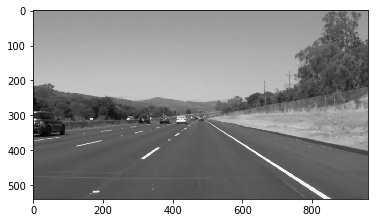

In [3]:
#reading in an image
original_img = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(original_img), 'with dimensions:', original_img.shape)
gray = cv2.cvtColor(original_img,cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 255, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #print(lines)
    '''
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    '''
    imshape=img.shape
    midx=imshape[1]/2
    midy=imshape[0]/2
    
    # split line coordinates into arrays
    negs_x1=[]
    negs_y1=[]
    negs_x2=[]
    negs_y2=[]
    poss_x1=[]
    poss_y1=[]
    poss_x2=[]
    poss_y2=[]
    
    # Slope threshold to reject any lines that are BELOW this slopw
    s_thresh=0.5
    
    # split line coordinates into arrays based on abs slope, 
    # slope direction - left or right line, position of x coordinate outside of trapezoid
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (x2-x1)>0:    # Prevent div by zero
                s=(y2-y1)/(x2-x1)
            if s > 0 and abs(s) > s_thresh and x1 > midx and x2 > midx:
                negs_x1.append(x1)
                negs_y1.append(y1)
                negs_x2.append(x2)
                negs_y2.append(y2)
            if s < 0 and abs(s) > s_thresh and x1 < midx and x2 < midx:
                poss_x1.append(x1)
                poss_y1.append(y1)
                poss_x2.append(x2)
                poss_y2.append(y2)
    
    # I didnt delete this unused code as it is a reference for me
    # it uses a reject_outliers function that I like but then later 
    # decided not to use
    '''            
    negs_x1=reject_outliers(negs_x1)
    negs_y1=reject_outliers(negs_y1)
    negs_x2=reject_outliers(negs_x2)
    negs_y2=reject_outliers(negs_y2)
    
    poss_x1=reject_outliers(poss_x1)
    poss_y1=reject_outliers(poss_y1)
    poss_x2=reject_outliers(poss_x2)
    poss_y2=reject_outliers(poss_y2)
    '''
    # Prepare x, y inputs for left and right lines for polyfit function
    neg_x_arr=np.concatenate((negs_x1, negs_x2), axis=0)
    neg_y_arr=np.concatenate((negs_y1, negs_y2), axis=0)
    pos_x_arr=np.concatenate((poss_x1, poss_x2), axis=0)
    pos_y_arr=np.concatenate((poss_y1, poss_y2), axis=0)
    
    # Polyfit for linear regression for best fit x and y
    if len(negs_x1)>0:
        neg_fit_m, neg_fit_b=np.polyfit(neg_x_arr,neg_y_arr,1)
        #print("neg")
        #print(neg_fit_m, neg_fit_b)
    
    if len(poss_x1)>0:
        pos_fit_m, pos_fit_b=np.polyfit(pos_x_arr,pos_y_arr,1)
        #print("pos")
        #print(pos_fit_m, pos_fit_b)
            
    miny = imshape[0]
    maxy = imshape[0]*(1-0.4)
    
    if len(negs_x1)>0: # Draw only if there is a negative slope line
        # Algorithm iteration - unused - kept for reference
        # x1=abs(int((maxy-max(negs_y1)+negs*max(negs_x1))/negs))
        # x2=abs(int((miny-min(negs_y2)+negs*min(negs_x2))/negs))
        # cv2.line(img,(min(negs_x2), min(negs_y2)) , (max(negs_x1), max(negs_y1)), color, thickness)
        x1=int((maxy - neg_fit_b) / neg_fit_m)
        y1=int(maxy)
        x2=int((miny - neg_fit_b) / neg_fit_m)
        y2=int(miny)
        cv2.line(img, (x1,y1),(x2,y2), color, thickness)

    if len(poss_x1)>0: # Draw only if there is a positive slope line
        # Algorithm iteration - unused - kept for reference
        # x3=abs(int((maxy-max(poss_y2)+poss*min(poss_x1))/poss))
        # x4=abs(int((miny-min(poss_y1)+poss*max(poss_x2))/poss))
        # print([x3, y3, x4, y4], [x1, y1, x2, y2])
        #cv2.line(img, (min(poss_x1), max(poss_y2)), (max(poss_x2), min(poss_y1)), color, thickness)

        x3=int((maxy - pos_fit_b) / pos_fit_m)
        y3=int(maxy)
        x4=int((miny - pos_fit_b) / pos_fit_m)
        y4=int(miny)
        cv2.line(img, (x3,y3),(x4,y4), color, thickness)


# Unused function - Kept for reference
def reject_outliers(data, m = 10.):
    if len(data)>3:
        d = np.abs(data - np.median(data))
        mdev = np.median(d)
        s = d/mdev if mdev else 0.
        e=[]
        #print([data, s])
        for i in range(0,len(s)):
            if s[i]<m:
                e.append(data[i])
    else:
        e=[]
        e=data
    return e

def hough_lines(masked_img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(masked_img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((masked_img.shape[0], masked_img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(initial_img, img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def filter_colors(img):
    #Filter the image to include only yellow and white pixels
    
    # Yellow
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([90,100,100])
    upper_yellow = np.array([110,255,255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    yellow_img = cv2.bitwise_and(img, img, mask=yellow_mask)

    # white
    white_thresh = 200
    lower_white = np.array([white_thresh, white_thresh, white_thresh])
    upper_white = np.array([255, 255, 255])
    white_mask = cv2.inRange(img, lower_white, upper_white)
    white_img = cv2.bitwise_and(img, img, mask=white_mask)

    # Add two images weighted
    filtered_img = cv2.addWeighted(white_img, 1., yellow_img, 1., 0.)

    return filtered_img

In [5]:
# Reject outliers test code - Ignore please.
d = [2,4,5,1,6,5,40]
s=reject_outliers(d)
print(s)

[2, 4, 5, 1, 6, 5]


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
os.listdir("test_images/")

['desktop.ini',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

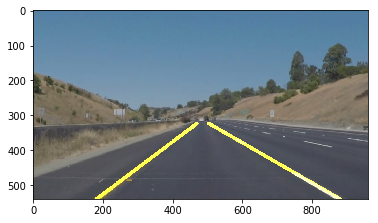

In [21]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
original_img = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
#plt.imshow(original_img)
filtered_img= filter_colors(original_img)
#plt.imshow(filtered_img)
gray_img=grayscale(filtered_img)
#plt.imshow(gray_img)
blurred_img=gaussian_blur(gray_img,5)
#plt.imshow(blurred_img)
canny_img=canny(blurred_img,50,150)
#plt.imshow(canny_img)
imshape = canny_img.shape
y=imshape[0]
x=imshape[1]
#print(y)
#print(x)
b_w = 0.85  # width of bottom edge of trapezoid
t_w = 0.07  # width of top edge of trapezoid
ht = 0.4  # height of the trapezoid

#vertices = np.array([[(75,y),((x/2)-15,(y/2)+45), ((x/2)+15, (y/2)+45),(x-75, y) ]], dtype=np.int32)
vertices = np.array([[\
                       ((x * (1 - b_w)) // 2, y),((x * (1 - t_w)) // 2, y - y * ht),\
                       (x - (x * (1 - t_w)) // 2, y - y * ht),(x - (x * (1 - b_w)) // 2, y)]],\
                       dtype=np.int32)
masked_img=region_of_interest(canny_img,vertices)
#plt.imshow(masked_img)
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 5 #minimum number of pixels making up a line
max_line_gap = 1    # maximum gap in pixels between connectable line segments

line_img=hough_lines(masked_img, rho, theta, threshold, min_line_len, max_line_gap)
#plt.imshow(line_img)
#color_edges = np.dstack((canny_img, canny_img, canny_img)) 
#plt.imshow(color_edges)
#print(color_edges.shape)
#print(line_img.shape)
weight_img=weighted_img(original_img, line_img)
plt.imshow(weight_img)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(original_img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    #original_img = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
    filtered_img= filter_colors(original_img)
    gray_img=grayscale(filtered_img)
    blurred_img=gaussian_blur(gray_img,5)
    canny_img=canny(blurred_img,50,150)
    imshape = canny_img.shape
    y=imshape[0]
    x=imshape[1]
    b_w = 0.85  # width of bottom edge of trapezoid
    t_w = 0.07  # width of top edge of trapezoid
    ht = 0.4  # height of the trapezoid

    vertices = np.array([[\
                           ((x * (1 - b_w)) // 2, y),((x * (1 - t_w)) // 2, y - y * ht),\
                           (x - (x * (1 - t_w)) // 2, y - y * ht),(x - (x * (1 - b_w)) // 2, y)]],\
                           dtype=np.int32)
    masked_img=region_of_interest(canny_img,vertices)
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 5 #minimum number of pixels making up a line
    max_line_gap = 1    # maximum gap in pixels between connectable line segments

    line_img=hough_lines(masked_img, rho, theta, threshold, min_line_len, max_line_gap)
    weight_img=weighted_img(original_img, line_img)
    return weight_img

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = 'test_videos/solidWhiteRight_out.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(8,8.84)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#%time 
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos/solidWhiteRight_out.mp4
[MoviePy] Writing video test_videos/solidWhiteRight_out.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:10<00:00, 21.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/solidWhiteRight_out.mp4 



Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'test_videos/solidYellowLeft_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos/solidYellowLeft_out.mp4
[MoviePy] Writing video test_videos/solidYellowLeft_out.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:30<00:00, 22.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/solidYellowLeft_out.mp4 

Wall time: 31.4 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [13]:
challenge_output = 'test_videos/challenge_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos/challenge_out.mp4
[MoviePy] Writing video test_videos/challenge_out.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:24<00:00, 10.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/challenge_out.mp4 

Wall time: 26.9 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))